In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import math

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [4]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [5]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [6]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7995,7995,0.333491,0.682035,0.220176,0.249060,0,NaN
7996,7996,0.344994,0.689298,0.225088,0.218040,1,NaN
7997,7997,0.390017,0.641338,0.211275,0.239294,1,NaN
7998,7998,0.324577,0.656867,0.205467,0.294698,1,NaN


In [7]:
#drop na columns 
all_df = all_df.dropna()
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7987,7987,0.325059,0.616790,0.235959,0.192175,2,4.0
7988,7988,0.388779,0.670864,0.243099,0.248306,2,3.0
7989,7989,0.339885,0.607819,0.237883,0.232814,3,2.0
7990,7990,0.525533,0.611479,0.414174,0.214225,3,1.0


In [8]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [9]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [10]:
#drop episodes with random failure in training set
train_data_cleaned = []
for train_episode in train_data:
    lastState = train_episode[-1][-1]
    if lastState < 5:
        train_data_cleaned.append(train_episode)

In [11]:
def splitDataIntoChunks3D(data, chunk_size): #chunk_size is 5
    X_split = []
    y_split = []
    time_split = []
    for episode in data:
        for order in range(0, len(episode)):
            diff = len(episode) - order
            if diff > chunk_size:
                episode_chunk = []
                for i in range(0, chunk_size):
                    reading = episode[order+i]
                    episode_chunk.append(reading[1:5])
                X_split.append(episode_chunk)
                y_split.append(episode[order+chunk_size][5])
                time_split.append(int(episode[order+chunk_size][0]))
    return (X_split, y_split, time_split)

In [12]:
#set random seed 
tf.random.set_seed(42)

In [13]:
def findSscore(actualRULlist, predictedRULlist):
    Sscore = 0
    for order in range(len(actualRULlist)):
        actualRUL = actualRULlist[order]
        predictedRUL = predictedRULlist[order]
        diff = abs(actualRUL - predictedRUL)
        if predictedRUL < actualRUL: #underestimate
            multiplier = 1/13
        else: #overestimate
            multiplier = 1/10
        factor = multiplier*diff
        score = math.exp(factor)
        Sscore += score
    return Sscore

### Attempt 1: Timestep = 4, 1D Convolution

In [15]:
(trainX_4step, trainY_4step, trainTime_4step) = splitDataIntoChunks3D(train_data, 4)
(valX_4step, valY_4step, valTime_4step) = splitDataIntoChunks3D(val_data, 4)
(testX_4step, testY_4step, testTime_4step) = splitDataIntoChunks3D(test_data, 4)

In [16]:
#check shape of X (training)
trainX_4step_arr = np.array(trainX_4step)
trainX_4step_arr.shape

(4022, 4, 4)

In [17]:
#check shape of y (training)
trainY_4step_arr = np.array(trainY_4step)
trainY_4step_arr = trainY_4step_arr.reshape(-1, 1)
trainY_4step_arr.shape

(4022, 1)

In [18]:
#check shape of X (validation)
valX_4step_arr = np.array(valX_4step)
valX_4step_arr.shape

(635, 4, 4)

In [19]:
#check shape of y (validation)
valY_4step_arr = np.array(valY_4step)
valY_4step_arr = valY_4step_arr.reshape(-1, 1)
valY_4step_arr.shape

(635, 1)

In [20]:
#configure architecture 
model1 = models.Sequential()
model1.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(4, 4), padding="same"))
model1.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding="same"))
model1.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model1.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Flatten())
model1.add(layers.Dense(100, activation='relu'))
model1.add(layers.Dense(1, activation='relu'))

In [21]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [22]:
fileName1 = "CNN_convolutionTest_1DConvolution.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName1,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [23]:
learning_model1 = model1.fit(trainX_4step_arr, trainY_4step_arr, epochs=500, batch_size=32, validation_data=(valX_4step_arr, valY_4step_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
126/126 [==============================] - 2s 9ms/step - loss: 23.9076 - mean_squared_error: 23.9076 - val_loss: 11.6124 - val_mean_squared_error: 11.6124
Epoch 2/500
126/126 [==============================] - 1s 6ms/step - loss: 19.6569 - mean_squared_error: 19.6569 - val_loss: 11.4242 - val_mean_squared_error: 11.4242
Epoch 3/500
126/126 [==============================] - 1s 6ms/step - loss: 19.1779 - mean_squared_error: 19.1779 - val_loss: 11.1962 - val_mean_squared_error: 11.1962
Epoch 4/500
126/126 [==============================] - 1s 6ms/step - loss: 19.2013 - mean_squared_error: 19.2013 - val_loss: 11.0856 - val_mean_squared_error: 11.0856
Epoch 5/500
126/126 [==============================] - 1s 5ms/step - loss: 19.1009 - mean_squared_error: 19.1009 - val_loss: 10.8884 - val_mean_squared_error: 10.8884
Epoch 6/500
126/126 [==============================] - 1s 6ms/step - loss: 18.5771 - mean_squared_error: 18.5771 - val_loss: 10.7401 - val_mean_squared_error: 10.740

126/126 [==============================] - 1s 4ms/step - loss: 16.2478 - mean_squared_error: 16.2478 - val_loss: 9.5485 - val_mean_squared_error: 9.5485
Epoch 100/500
126/126 [==============================] - 1s 5ms/step - loss: 16.2227 - mean_squared_error: 16.2227 - val_loss: 9.7116 - val_mean_squared_error: 9.7116
Epoch 101/500
126/126 [==============================] - 1s 4ms/step - loss: 16.3232 - mean_squared_error: 16.3232 - val_loss: 9.6343 - val_mean_squared_error: 9.6343
Epoch 102/500
126/126 [==============================] - 1s 4ms/step - loss: 16.2397 - mean_squared_error: 16.2397 - val_loss: 9.5675 - val_mean_squared_error: 9.5675
Epoch 103/500
126/126 [==============================] - 1s 4ms/step - loss: 16.2991 - mean_squared_error: 16.2991 - val_loss: 9.6781 - val_mean_squared_error: 9.6781
Epoch 104/500
126/126 [==============================] - 1s 4ms/step - loss: 16.1441 - mean_squared_error: 16.1441 - val_loss: 9.6905 - val_mean_squared_error: 9.6905
Epoch 105/50

Epoch 197/500
126/126 [==============================] - 1s 5ms/step - loss: 14.9650 - mean_squared_error: 14.9650 - val_loss: 10.2940 - val_mean_squared_error: 10.2940
Epoch 198/500
126/126 [==============================] - 1s 4ms/step - loss: 14.9271 - mean_squared_error: 14.9271 - val_loss: 10.1550 - val_mean_squared_error: 10.1550
Epoch 199/500
126/126 [==============================] - 1s 4ms/step - loss: 15.1361 - mean_squared_error: 15.1361 - val_loss: 10.0896 - val_mean_squared_error: 10.0896
Epoch 200/500
126/126 [==============================] - 1s 5ms/step - loss: 14.9523 - mean_squared_error: 14.9523 - val_loss: 9.9645 - val_mean_squared_error: 9.9645
Epoch 201/500
126/126 [==============================] - 1s 4ms/step - loss: 15.0464 - mean_squared_error: 15.0464 - val_loss: 10.1066 - val_mean_squared_error: 10.1066
Epoch 202/500
126/126 [==============================] - 1s 4ms/step - loss: 15.2663 - mean_squared_error: 15.2663 - val_loss: 10.1600 - val_mean_squared_err

126/126 [==============================] - 1s 5ms/step - loss: 14.3193 - mean_squared_error: 14.3193 - val_loss: 10.5297 - val_mean_squared_error: 10.5297
Epoch 294/500
126/126 [==============================] - 1s 5ms/step - loss: 14.2511 - mean_squared_error: 14.2511 - val_loss: 10.4925 - val_mean_squared_error: 10.4925
Epoch 295/500
126/126 [==============================] - 1s 5ms/step - loss: 14.2955 - mean_squared_error: 14.2955 - val_loss: 10.4569 - val_mean_squared_error: 10.4569
Epoch 296/500
126/126 [==============================] - 1s 5ms/step - loss: 14.2944 - mean_squared_error: 14.2944 - val_loss: 10.6138 - val_mean_squared_error: 10.6138
Epoch 297/500
126/126 [==============================] - 1s 4ms/step - loss: 14.3020 - mean_squared_error: 14.3020 - val_loss: 10.4990 - val_mean_squared_error: 10.4990
Epoch 298/500
126/126 [==============================] - 1s 4ms/step - loss: 14.3849 - mean_squared_error: 14.3849 - val_loss: 10.9109 - val_mean_squared_error: 10.9109


126/126 [==============================] - 1s 5ms/step - loss: 13.1378 - mean_squared_error: 13.1378 - val_loss: 10.9558 - val_mean_squared_error: 10.9558
Epoch 390/500
126/126 [==============================] - 1s 5ms/step - loss: 13.4170 - mean_squared_error: 13.4170 - val_loss: 10.5814 - val_mean_squared_error: 10.5814
Epoch 391/500
126/126 [==============================] - 1s 4ms/step - loss: 13.6964 - mean_squared_error: 13.6964 - val_loss: 11.0969 - val_mean_squared_error: 11.0969
Epoch 392/500
126/126 [==============================] - 1s 5ms/step - loss: 13.1929 - mean_squared_error: 13.1929 - val_loss: 10.8840 - val_mean_squared_error: 10.8840
Epoch 393/500
126/126 [==============================] - 1s 4ms/step - loss: 14.0369 - mean_squared_error: 14.0369 - val_loss: 10.8568 - val_mean_squared_error: 10.8568
Epoch 394/500
126/126 [==============================] - 1s 5ms/step - loss: 13.4017 - mean_squared_error: 13.4017 - val_loss: 11.2262 - val_mean_squared_error: 11.2262


126/126 [==============================] - 1s 5ms/step - loss: 12.3223 - mean_squared_error: 12.3223 - val_loss: 11.0952 - val_mean_squared_error: 11.0952
Epoch 486/500
126/126 [==============================] - 1s 5ms/step - loss: 12.2745 - mean_squared_error: 12.2745 - val_loss: 11.7913 - val_mean_squared_error: 11.7913
Epoch 487/500
126/126 [==============================] - 1s 5ms/step - loss: 12.3569 - mean_squared_error: 12.3569 - val_loss: 11.2031 - val_mean_squared_error: 11.2031
Epoch 488/500
126/126 [==============================] - 1s 5ms/step - loss: 12.6111 - mean_squared_error: 12.6111 - val_loss: 11.7299 - val_mean_squared_error: 11.7299
Epoch 489/500
126/126 [==============================] - 1s 6ms/step - loss: 12.2555 - mean_squared_error: 12.2555 - val_loss: 11.2213 - val_mean_squared_error: 11.2213
Epoch 490/500
126/126 [==============================] - 1s 6ms/step - loss: 12.5407 - mean_squared_error: 12.5407 - val_loss: 10.7646 - val_mean_squared_error: 10.7646


In [24]:
model1 = tf.keras.models.load_model('CNN_convolutionTest_1DConvolution.h5')

In [25]:
#performance on training set
trainPredict1 = model1.predict(trainX_4step_arr)
# calculate root mean squared error
trainScore1 = math.sqrt(mean_squared_error(trainY_4step_arr, trainPredict1))
trainR2Score1 = r2_score(trainY_4step_arr, trainPredict1)
trainSscore1 = findSscore(trainY_4step_arr, trainPredict1)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore1, trainR2Score1, trainSscore1))

Train Score: 4.1163 RMSE 0.0924 R2 Score 5361.3541 S score


In [26]:
#performance on validation set
valPredict1 = model1.predict(valX_4step_arr)
# calculate root mean squared error
valScore1 = math.sqrt(mean_squared_error(valY_4step_arr, valPredict1))
valR2Score1 = r2_score(valY_4step_arr, valPredict1)
valSscore1 = findSscore(valY_4step_arr, valPredict1)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore1, valR2Score1, valSscore1))

Validation Score: 3.0797 RMSE 0.1720 R2 Score 802.4931 S score


In [27]:
def getRULValues(predictions, actual, timeList, startIndex, endIndex):
    actualValues = []
    predictedValues = []
    for timestep in range(startIndex, endIndex+1):
        actualValues.append(actual[timestep])
        if timestep in timeList:
            requiredIndex = timeList.index(timestep)
            predictedValues.append(predictions[requiredIndex])
        else:
            predictedValues.append(0)
    return (actualValues, predictedValues)

In [28]:
allRUL = all_df['RUL']
(actualVal1, predictedVal1) = getRULValues(valPredict1, allRUL, valTime_4step, 6010, 6976)

C:\Users\NG ZHI QING\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


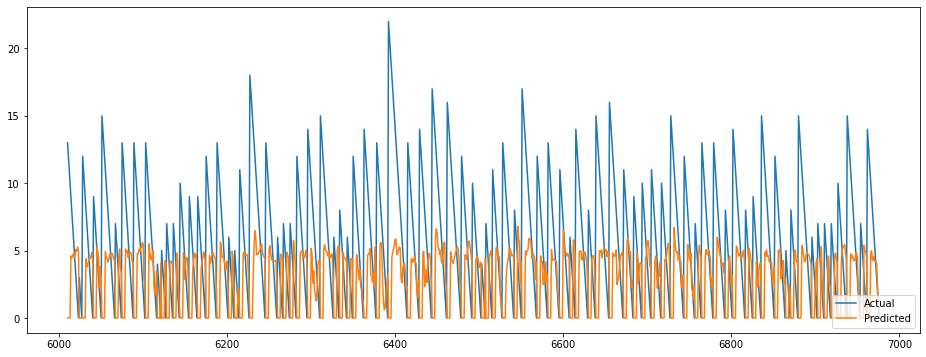

In [29]:
#validation set
timeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(timeLabels, actualVal1)
plt.plot(timeLabels, predictedVal1)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

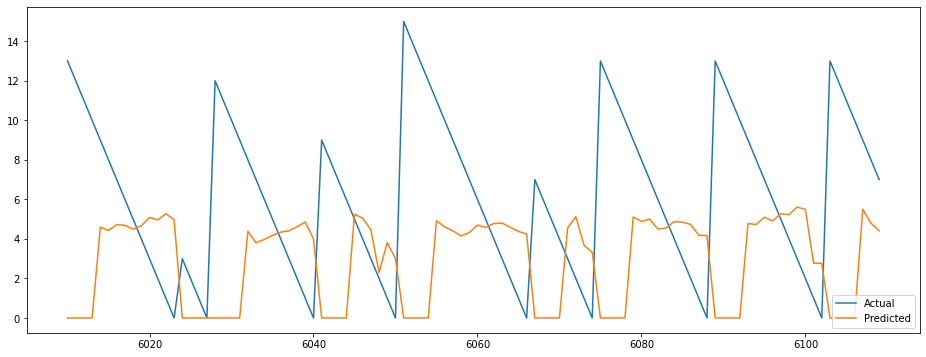

In [30]:
plt.figure(figsize=(16, 6))
plt.plot(timeLabels[0:100], actualVal1[0:100])
plt.plot(timeLabels[0:100], predictedVal1[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

In [31]:
(actualTrain1, predictedTrain1) = getRULValues(trainPredict1, allRUL, trainTime_4step, 0, 6009)

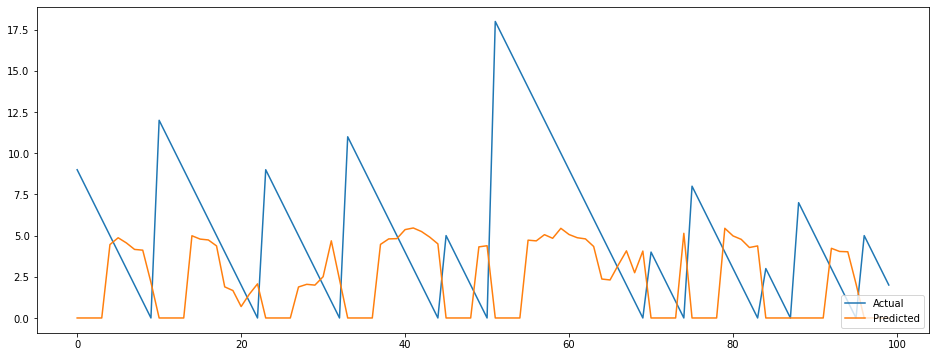

In [32]:
#look at training set
trainTimeLabels = [i for i in range(6010)]
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels[0:100], actualTrain1[0:100])
plt.plot(trainTimeLabels[0:100], predictedTrain1[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

### Attempt 2: Timestep = 4, 2D convolution

In [33]:
#reshape input to 4D for 2D convolution
trainX_4step_arr_4D = np.reshape(trainX_4step_arr, (len(trainX_4step_arr), 4, 4, 1))

valX_4step_arr_4D = np.reshape(valX_4step_arr, (len(valX_4step_arr), 4, 4, 1))

In [34]:
model2 = models.Sequential()
model2.add(layers.Conv2D(filters=128, kernel_size=(2,2), activation='relu', dilation_rate=1, input_shape=(4, 4, 1), data_format="channels_last", padding="same"))
model2.add(layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu', dilation_rate=1, padding="same"))
model2.add(layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', dilation_rate=2, padding="same"))
model2.add(layers.Conv2D(filters=16, kernel_size=(2,2), activation='relu', dilation_rate=2, padding="same"))
model2.add(layers.Conv2D(filters=1, kernel_size=(2,2), activation='relu', padding="same"))
model2.add(layers.Flatten())
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(1, activation='relu'))

In [35]:
model2.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [36]:
fileName2 = "CNN_convolutionTest_2DConvolution.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName2,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [37]:
learning_model2 = model2.fit(trainX_4step_arr_4D, trainY_4step_arr, epochs=500, batch_size=32, validation_data=(valX_4step_arr_4D, valY_4step_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
126/126 [==============================] - 3s 14ms/step - loss: 21.3078 - mean_squared_error: 21.3078 - val_loss: 12.4321 - val_mean_squared_error: 12.4321
Epoch 2/500
126/126 [==============================] - 1s 11ms/step - loss: 19.2461 - mean_squared_error: 19.2461 - val_loss: 12.5805 - val_mean_squared_error: 12.5805
Epoch 3/500
126/126 [==============================] - 1s 11ms/step - loss: 19.0685 - mean_squared_error: 19.0685 - val_loss: 12.2442 - val_mean_squared_error: 12.2442
Epoch 4/500
126/126 [==============================] - 1s 11ms/step - loss: 18.9444 - mean_squared_error: 18.9444 - val_loss: 12.0686 - val_mean_squared_error: 12.0686
Epoch 5/500
126/126 [==============================] - 1s 11ms/step - loss: 18.8688 - mean_squared_error: 18.8688 - val_loss: 11.8985 - val_mean_squared_error: 11.8985
Epoch 6/500
126/126 [==============================] - 1s 11ms/step - loss: 18.7880 - mean_squared_error: 18.7880 - val_loss: 11.7845 - val_mean_squared_error: 

Epoch 50/500
126/126 [==============================] - 1s 11ms/step - loss: 16.6876 - mean_squared_error: 16.6876 - val_loss: 9.7279 - val_mean_squared_error: 9.7279
Epoch 51/500
126/126 [==============================] - 1s 11ms/step - loss: 16.6749 - mean_squared_error: 16.6749 - val_loss: 9.7179 - val_mean_squared_error: 9.7179
Epoch 52/500
126/126 [==============================] - 1s 11ms/step - loss: 16.6682 - mean_squared_error: 16.6682 - val_loss: 9.7030 - val_mean_squared_error: 9.7030
Epoch 53/500
126/126 [==============================] - 1s 10ms/step - loss: 16.6438 - mean_squared_error: 16.6438 - val_loss: 9.7108 - val_mean_squared_error: 9.7108
Epoch 54/500
126/126 [==============================] - 1s 11ms/step - loss: 16.6298 - mean_squared_error: 16.6298 - val_loss: 9.6829 - val_mean_squared_error: 9.6829
Epoch 55/500
126/126 [==============================] - 1s 10ms/step - loss: 16.6517 - mean_squared_error: 16.6517 - val_loss: 9.8062 - val_mean_squared_error: 9.806

Epoch 99/500
126/126 [==============================] - 1s 10ms/step - loss: 15.7216 - mean_squared_error: 15.7216 - val_loss: 10.0353 - val_mean_squared_error: 10.0353
Epoch 100/500
126/126 [==============================] - 1s 10ms/step - loss: 15.7221 - mean_squared_error: 15.7221 - val_loss: 9.9458 - val_mean_squared_error: 9.9458
Epoch 101/500
126/126 [==============================] - 1s 10ms/step - loss: 15.6818 - mean_squared_error: 15.6818 - val_loss: 10.0358 - val_mean_squared_error: 10.0358
Epoch 102/500
126/126 [==============================] - 1s 10ms/step - loss: 15.7082 - mean_squared_error: 15.7082 - val_loss: 10.0015 - val_mean_squared_error: 10.0015
Epoch 103/500
126/126 [==============================] - 1s 10ms/step - loss: 15.6784 - mean_squared_error: 15.6784 - val_loss: 9.8630 - val_mean_squared_error: 9.8630
Epoch 104/500
126/126 [==============================] - 1s 10ms/step - loss: 15.6753 - mean_squared_error: 15.6753 - val_loss: 10.0552 - val_mean_squared_

126/126 [==============================] - 1s 10ms/step - loss: 13.7780 - mean_squared_error: 13.7780 - val_loss: 11.2875 - val_mean_squared_error: 11.2875
Epoch 196/500
126/126 [==============================] - 1s 10ms/step - loss: 13.8009 - mean_squared_error: 13.8009 - val_loss: 11.1624 - val_mean_squared_error: 11.1624
Epoch 197/500
126/126 [==============================] - 1s 10ms/step - loss: 13.8832 - mean_squared_error: 13.8832 - val_loss: 11.0794 - val_mean_squared_error: 11.0794
Epoch 198/500
126/126 [==============================] - 1s 11ms/step - loss: 13.9172 - mean_squared_error: 13.9172 - val_loss: 11.3042 - val_mean_squared_error: 11.3042
Epoch 199/500
126/126 [==============================] - 1s 11ms/step - loss: 13.6981 - mean_squared_error: 13.6981 - val_loss: 11.2587 - val_mean_squared_error: 11.2587
Epoch 200/500
126/126 [==============================] - 1s 11ms/step - loss: 13.5623 - mean_squared_error: 13.5623 - val_loss: 11.4596 - val_mean_squared_error: 11

126/126 [==============================] - 1s 11ms/step - loss: 10.0919 - mean_squared_error: 10.0919 - val_loss: 15.1535 - val_mean_squared_error: 15.1535
Epoch 292/500
126/126 [==============================] - 1s 10ms/step - loss: 9.7785 - mean_squared_error: 9.7785 - val_loss: 16.0539 - val_mean_squared_error: 16.0539
Epoch 293/500
126/126 [==============================] - 1s 10ms/step - loss: 9.7806 - mean_squared_error: 9.7806 - val_loss: 15.0390 - val_mean_squared_error: 15.0390
Epoch 294/500
126/126 [==============================] - 1s 10ms/step - loss: 9.8244 - mean_squared_error: 9.8244 - val_loss: 15.4887 - val_mean_squared_error: 15.4887
Epoch 295/500
126/126 [==============================] - 1s 11ms/step - loss: 10.5077 - mean_squared_error: 10.5077 - val_loss: 16.2561 - val_mean_squared_error: 16.2561
Epoch 296/500
126/126 [==============================] - 1s 11ms/step - loss: 10.3352 - mean_squared_error: 10.3352 - val_loss: 16.0781 - val_mean_squared_error: 16.0781


Epoch 388/500
126/126 [==============================] - 1s 11ms/step - loss: 9.0746 - mean_squared_error: 9.0746 - val_loss: 15.4319 - val_mean_squared_error: 15.4319
Epoch 389/500
126/126 [==============================] - 1s 10ms/step - loss: 9.0736 - mean_squared_error: 9.0736 - val_loss: 14.9883 - val_mean_squared_error: 14.9883
Epoch 390/500
126/126 [==============================] - 1s 10ms/step - loss: 8.6198 - mean_squared_error: 8.6198 - val_loss: 15.0143 - val_mean_squared_error: 15.0143
Epoch 391/500
126/126 [==============================] - 1s 10ms/step - loss: 8.7718 - mean_squared_error: 8.7718 - val_loss: 15.3679 - val_mean_squared_error: 15.3679
Epoch 392/500
126/126 [==============================] - 1s 10ms/step - loss: 9.0477 - mean_squared_error: 9.0477 - val_loss: 15.1547 - val_mean_squared_error: 15.1547
Epoch 393/500
126/126 [==============================] - 1s 11ms/step - loss: 9.0119 - mean_squared_error: 9.0119 - val_loss: 15.0692 - val_mean_squared_error: 

Epoch 437/500
126/126 [==============================] - 1s 10ms/step - loss: 7.3647 - mean_squared_error: 7.3647 - val_loss: 16.0759 - val_mean_squared_error: 16.0759
Epoch 438/500
126/126 [==============================] - 1s 11ms/step - loss: 7.1342 - mean_squared_error: 7.1342 - val_loss: 15.9720 - val_mean_squared_error: 15.9720
Epoch 439/500
126/126 [==============================] - 1s 11ms/step - loss: 7.3339 - mean_squared_error: 7.3339 - val_loss: 15.9736 - val_mean_squared_error: 15.9736
Epoch 440/500
126/126 [==============================] - 1s 11ms/step - loss: 7.5958 - mean_squared_error: 7.5958 - val_loss: 15.9995 - val_mean_squared_error: 15.9995
Epoch 441/500
126/126 [==============================] - 1s 12ms/step - loss: 7.0312 - mean_squared_error: 7.0312 - val_loss: 16.2743 - val_mean_squared_error: 16.2743
Epoch 442/500
126/126 [==============================] - 1s 12ms/step - loss: 6.8713 - mean_squared_error: 6.8713 - val_loss: 15.8906 - val_mean_squared_error: 

Epoch 486/500
126/126 [==============================] - 1s 11ms/step - loss: 7.1304 - mean_squared_error: 7.1304 - val_loss: 19.4688 - val_mean_squared_error: 19.4688
Epoch 487/500
126/126 [==============================] - 1s 11ms/step - loss: 8.0220 - mean_squared_error: 8.0220 - val_loss: 17.9183 - val_mean_squared_error: 17.9183
Epoch 488/500
126/126 [==============================] - 2s 12ms/step - loss: 7.8037 - mean_squared_error: 7.8037 - val_loss: 18.2967 - val_mean_squared_error: 18.2967
Epoch 489/500
126/126 [==============================] - 1s 11ms/step - loss: 7.3291 - mean_squared_error: 7.3291 - val_loss: 17.7321 - val_mean_squared_error: 17.7321
Epoch 490/500
126/126 [==============================] - 1s 12ms/step - loss: 7.5406 - mean_squared_error: 7.5406 - val_loss: 16.8597 - val_mean_squared_error: 16.8597
Epoch 491/500
126/126 [==============================] - 1s 11ms/step - loss: 7.4036 - mean_squared_error: 7.4036 - val_loss: 18.4406 - val_mean_squared_error: 

In [38]:
model2 = tf.keras.models.load_model('CNN_convolutionTest_2DConvolution.h5')

In [39]:
#performance on training set
trainPredict2 = model2.predict(trainX_4step_arr_4D)
# calculate root mean squared error
trainScore2 = math.sqrt(mean_squared_error(trainY_4step_arr, trainPredict2))
trainR2Score2 = r2_score(trainY_4step_arr, trainPredict2)
trainSscore2 = findSscore(trainY_4step_arr, trainPredict2)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore2, trainR2Score2, trainSscore2))

Train Score: 4.0161 RMSE 0.1361 R2 Score 5395.2123 S score


In [40]:
#performance on validation set (all data only)
valPredict2 = model2.predict(valX_4step_arr_4D)
# calculate root mean squared error
valScore2 = math.sqrt(mean_squared_error(valY_4step_arr, valPredict2))
valR2Score2 = r2_score(valY_4step_arr, valPredict2)
valSscore2 = findSscore(valY_4step_arr, valPredict2)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore2, valR2Score2, valSscore2))

Validation Score: 3.1106 RMSE 0.1553 R2 Score 812.8666 S score


In [41]:
(actualVal2, predictedVal2) = getRULValues(valPredict2, allRUL, valTime_4step, 6010, 6976)

C:\Users\NG ZHI QING\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


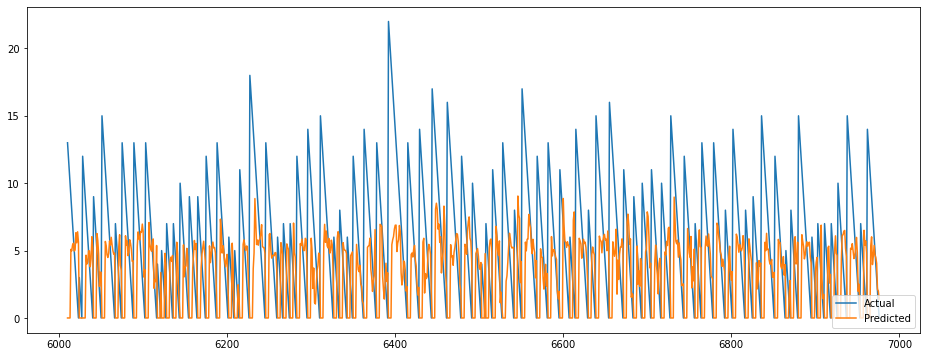

In [42]:
#validation set
timeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(timeLabels, actualVal2)
plt.plot(timeLabels, predictedVal2)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

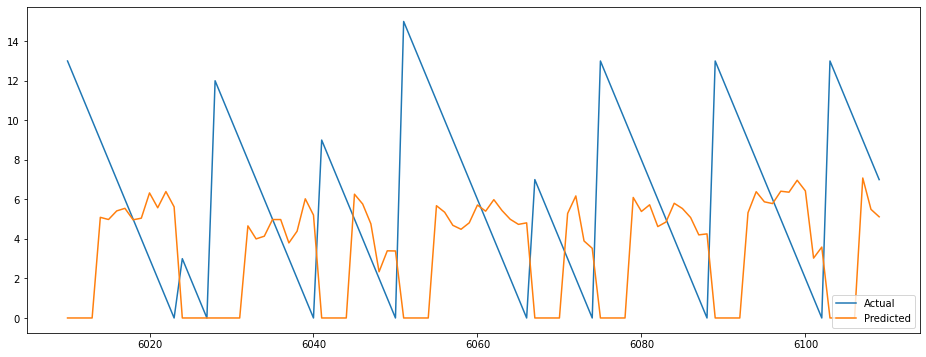

In [43]:
plt.figure(figsize=(16, 6))
plt.plot(timeLabels[0:100], actualVal2[0:100])
plt.plot(timeLabels[0:100], predictedVal2[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

In [44]:
trainTime_4step[-1]

6009

In [45]:
(actualTrain2, predictedTrain2) = getRULValues(trainPredict2, allRUL, trainTime_4step, 0, 6009)

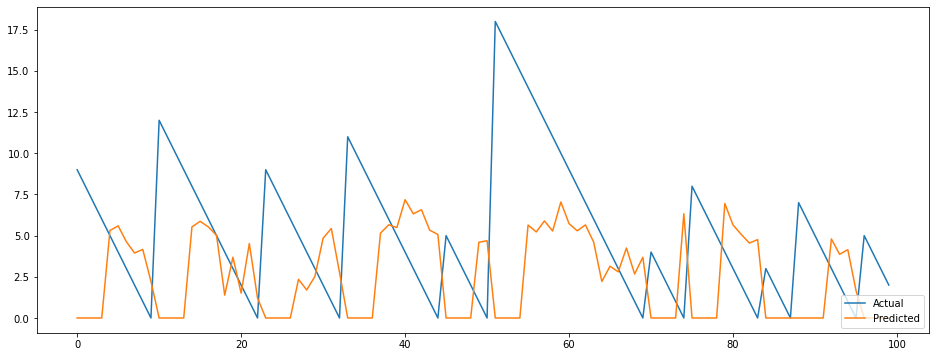

In [46]:
#look at training set
trainTimeLabels = [i for i in range(6010)]
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels[0:100], actualTrain2[0:100])
plt.plot(trainTimeLabels[0:100], predictedTrain2[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()